In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
%load_ext watermark
%watermark -v -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

sklearn   : 0.23.2
pymc3     : 3.9.3
theano    : 1.0.5
seaborn   : 0.11.0
numpy     : 1.19.2
arviz     : 0.10.0
pandas    : 1.1.3
matplotlib: 3.3.2



### Data

In [5]:
from sklearn.datasets import make_classification

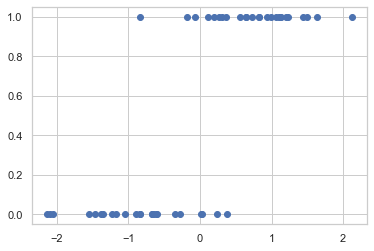

In [10]:
np.random.seed(42)
data_x, data_y = make_classification(n_samples=50, n_features=1, n_informative=1, n_redundant=0, n_repeated=0, n_clusters_per_class=1)
data_x = data_x.flatten()

fig, ax = plt.subplots()
ax.scatter(data_x, data_y);

### PyMC3 Model

In [27]:
def classifier_model(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1)

        # model
        p = pm.Deterministic('p', pm.math.invlogit(β * x + α))
        y_hat = pm.Bernoulli('y_hat', p=p, observed=y)
    return model

In [28]:
pm_clf = classifier_model(data_x, data_y)
pm_clf

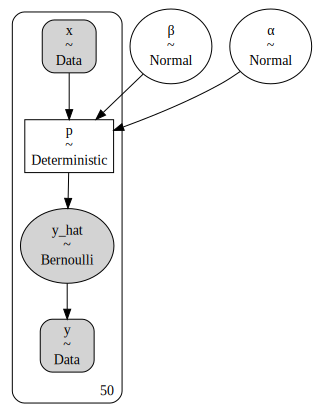

In [29]:
pm.model_to_graphviz(pm_clf)

In [30]:
with pm_clf:
    # Prior sampling, trace definition and posterior sampling
    pm_clf_prior = pm.sample_prior_predictive()
    pm_clf_posterior = pm.sample(tune=1500)
    pm_clf_posterior_pred = pm.sample_posterior_predictive(pm_clf_posterior)
pm_clf_inf_obj = az.from_pymc3(prior=pm_clf_prior, trace=pm_clf_posterior, posterior_predictive=pm_clf_posterior_pred,
                               model=pm_clf)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 22 seconds.


In [33]:
az.to_netcdf(pm_clf_inf_obj, 'model_21.netcdf')
pm_clf_inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [34]:
pm_clf_inf_obj = az.from_netcdf('model_21.netcdf')
pm_clf_inf_obj

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

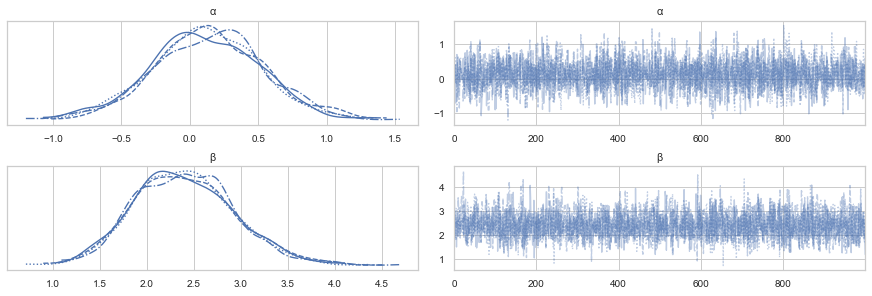

In [31]:
pm.traceplot(pm_clf_inf_obj, var_names=['~p']);

In [32]:
az.summary(pm_clf_inf_obj, var_names=['~p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.130,0.398,-0.608,0.899,0.007,0.006,3160.0,1936.0,3177.0,2429.0,1.0
β,2.403,0.530,1.391,3.343,0.009,0.007,3187.0,3027.0,3197.0,2650.0,1.0


In [37]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

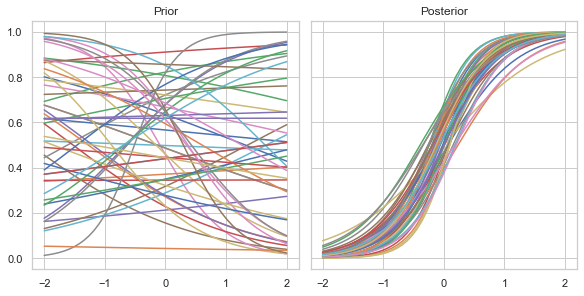

In [67]:
nshow = 50

samples = 500 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, constrained_layout=True, figsize=(8,4))
for α, β in zip(pm_clf_inf_obj.prior.get('α').values.flatten()[idx], 
                pm_clf_inf_obj.prior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax1.plot(xs, logistic(β * xs + α))
ax1.set(title='Prior');

samples = 1000 # default n_samples in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β in zip(pm_clf_inf_obj.posterior.get('α').values.flatten()[idx], 
                pm_clf_inf_obj.posterior.get('β').values.flatten()[idx]):
    xs = np.linspace(-2, 2)
    ax2.plot(xs, logistic(β * xs + α))
ax2.set(title='Posterior');

# for ax in (ax1,ax2):
#     ax.set(aspect='equal')

### sklearn Model

In [43]:
clf = LogisticRegression()
clf.fit(data_x[:,np.newaxis], data_y)

LogisticRegression()

### Analysis and Comparison

In [50]:
# dummy Y values are passed (these are not used for calculations but a vector of correct shape needs to be given here)
xs = np.linspace(-2, 2)
with classifier_model(xs, np.zeros_like(xs)) as pm_clf:
    # use training trace to generate posterior samples on test set
    new_preds = pm.sample_posterior_predictive(pm_clf_posterior)

C:\Users\ruote\Anaconda3\envs\pymc\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


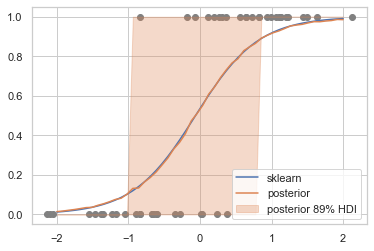

In [53]:
fig, ax = plt.subplots()

ax.scatter(data_x, data_y, color='gray');

xs = np.linspace(-2, 2)
ax.plot(xs, logistic(clf.coef_[0][0] * xs + clf.intercept_[0]), label='sklearn')

hdi = az.hdi(new_preds['y_hat'], hdi_prob=0.89)
ax.fill_between(xs, hdi[:,0], hdi[:,1], alpha=0.3, color='C1', label='posterior 89% HDI')
ax.plot(xs, new_preds['y_hat'].mean(axis=0), color='C1', label='posterior')

ax.legend()

In [62]:
df = pd.DataFrame([data_x, data_y]).T
df.columns = ['x', 'y']
df['x_cut'] = pd.cut(df['x'], bins=[-np.inf,-1,0,1,np.inf], include_lowest=True, right=True)
df.groupby('x_cut')['y'].mean()

x_cut
(-inf, -1.0]    0.000000
(-1.0, 0.0]     0.230769
(0.0, 1.0]      0.764706
(1.0, inf]      1.000000
Name: y, dtype: float64